# CNN Cancer Detection Kaggle Mini-Project

## Histopathologic Cancer Detection

## For CSCA5642 Week 3

### Step 1
#### Brief Description of the Problem and Data

In this competition, we are tasked with classifying a large number of pathology images. Each image is 32x32 pixels, and the goal is to determine whether the center 32x32px region of a patch contains at least one pixel of tumor tissue.

- A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.
- Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.
- The `train_labels.csv` file provides the ground truth for the images in the `train` folder.
- The evaluation metric is the Area Under the ROC Curve (AUC).
- The size of the training set is 220_025 instances. The test set is 57_458 instances
- Each tif files are 96x96, but we only need the center 32x32

### Directory structure

```
/kaggle/input/histopathologic-cancer-detection/ or local ./
├── train/
│   ├── 1.tif    # filenames are in the structure of id.tif
│   ├── 2.tif    # files are 96x96 TIFF files. only the center 32x32 is necessary
│   ├── ...
│   └── n.tif
├── test/
│   ├── 1.tif    # filenames are in the structure of id.tif
│   ├── 2.tif    # each are 96x96 TIFFs. only the center 32x32 is necessary
│   ├── ...
│   └── m.tif
├── sample_submission.csv  # CSV in the form of id,label where label is 0 or 1
└── train_labels.csv
```

The challenge involves classifying small pathology images (96x96 pixels) to determine if they contain cancer tissue. The dataset consists of TIF images, with labels indicating whether the center 32x32 pixel region contains at least one pixel of tumor tissue.
Whole file is 96x96x3 with each channel being 8bits
### Data structure (when online otherwise ./train etc)
- **Train images:** `/kaggle/input/histopathologic-cancer-detection/train/`
- **Test images:** `/kaggle/input/histopathologic-cancer-detection/test/`
- **Train labels:** `/kaggle/input/histopathologic-cancer-detection/train_labels.csv`
- **Sample submission:** `/kaggle/input/histopathologic-cancer-detection/sample_submission.csv`

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from torchvision.transforms import v2
# others
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
# import tensorboardX
from tqdm import tqdm

In [2]:
# Set up paths
# path = Path('/kaggle/input/histopathologic-cancer-detection')
path = Path('./') # operating locally
train_path = path / 'train'
test_path = path / 'test'

# Load train labels
train_label_data = pd.read_csv(path / 'train_labels.csv')

# Step 2a : Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


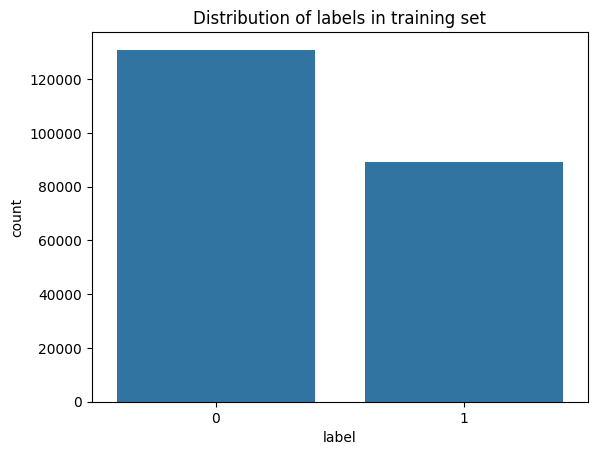

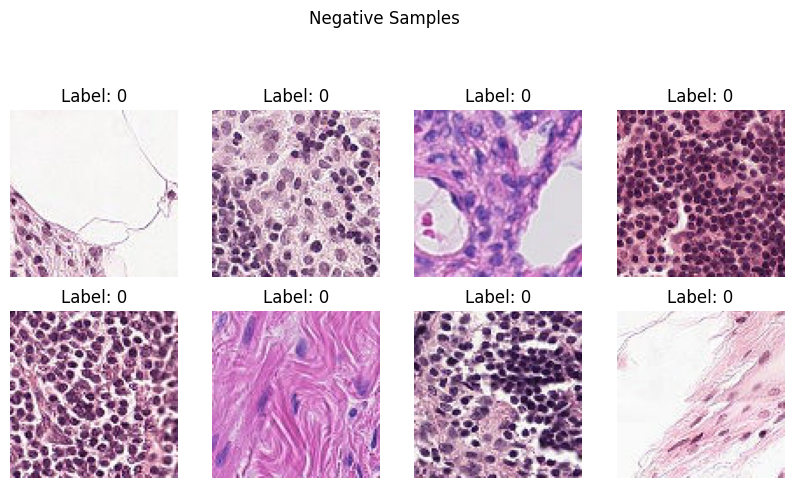

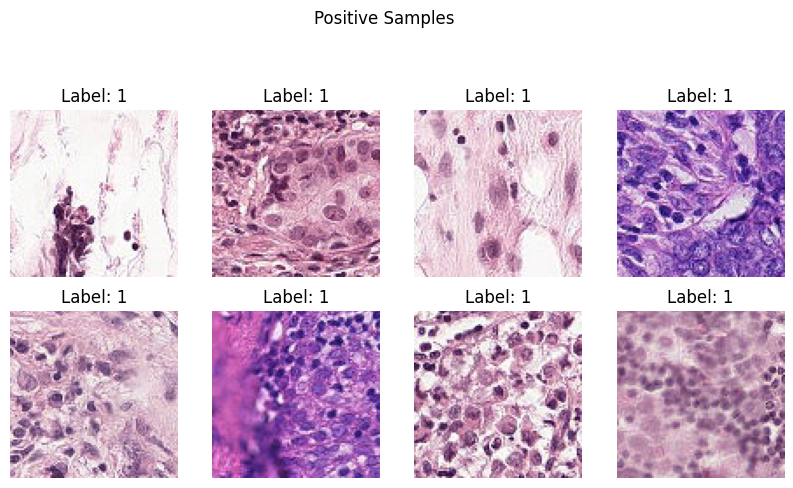

In [3]:
# Step 2: Exploratory Data Analysis (EDA)
# Display the first few rows
train_label_data.head()
# Display basic information about the dataset
print(train_label_data.info())
print(train_label_data['label'].value_counts(normalize=True))

# Visualize class distribution and check for class imbalance
sns.countplot(x='label', data=train_label_data)
plt.title('Distribution of labels in training set')
plt.show()


# Display a few example images from each class
def display_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i, img_id in enumerate(images):
        img = Image.open(train_path / f'{img_id}.tif')
        plt.subplot(4, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


# Display example images with label 0
neg_images = train_label_data[train_label_data['label'] == 0]['id'].values[:8]
display_images(neg_images, [0] * 8, 'Negative Samples')

# Display example images with label 1
pos_images = train_label_data[train_label_data['label'] == 1]['id'].values[:8]
display_images(pos_images, [1] * 8, 'Positive Samples')

# Step 2b Clean and preprocess the Data

In [4]:
# Normalize the image tensor with mean and std dev of ImageNet dataset
    # This is a common practice when using models pre-trained on ImageNet
    # It helps the model converge faster and perform better
    # Formula applied: (image - mean) / std
    # The values are per-channel for RGB images
    # Convert PIL Image to tensor and scales values to [0.0, 1.0]
 # Crop the center 32x32 region of the image
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.CenterCrop(32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Custom Dataset class
class CancerDataset(Dataset):
    def __init__(self, image_ids, labels, img_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
        #label = self.labels[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# Create train and validation datasets
train_ids, val_ids, train_y, val_y = train_test_split(
    train_label_data['id'], train_label_data['label'], test_size=0.2, random_state=42
)

train_dataset = CancerDataset(train_ids.values, train_y.values, train_path, transform=transform)
val_dataset = CancerDataset(val_ids.values, val_y.values, train_path, transform=transform)

#setup calculations
torch.set_float32_matmul_precision('medium') # or 'high'

In [6]:
# Step 3: Model Architectures

# Pre-built ConvNext model
class CancerDetectionModel(pl.LightningModule):
    def __init__(self, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        
        # Freeze all layers except the last one. commenting this out trains the fullmodel
        #for param in self.model.parameters():
        #    param.requires_grad = False
        
        # Replace the final layer
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)
        
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat.squeeze(), y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [7]:
# Initialize model
model = CancerDetectionModel()

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename='cancer-detection-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min'
)

# Logger
logger = TensorBoardLogger("lightning_logs", name="cancer_detection")

# Model Training

#### I have conducted the following hyperparameter tuning with batch sizes
batch size, VRAM consumption, seconds per epoch, private score, public score
batch_size = 32 # 3gib 56s/epoch
batch_size = 64 # 3 Gib  35s/epoch 0.762 / 0.790 
batch_size = 128 # 2.4 Gib  31s/epoch 0.763/0.791
batch_size = 256 # 2.5 gib 30s/epoch 0.757/0.787
batch_size = 512 # 2.7 gib 30s/epoch 0.757/0.787
batch_size = 1024  # 2.7 gib 10 s/epoch 0.757/0.787 (started using pinmemory)

In [18]:
# batch_size = 32 # 3gib 56s/epoch
# batch_size = 64 # 3 Gib  35s/epoch 
# batch_size = 128 # 2.4 Gib  31s/epoch 0.763/0.791
# batch_size = 256 # 2.5 gib 30s/epoch 0.757/0.787
# batch_size = 512 # 2.5 gib 30s/epoch 0.756 / 0.786
# batch_size = 1024 # 3gib 10s 0.753/0.780
batch_size = 2048
max_epochs = 10
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
# Trainer with mixed precision
trainer = pl.Trainer(
    max_epochs=max_epochs,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    precision='16-mixed',  # Enable mixed precision training
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
# Train the model
trainer.fit(model, train_loader, val_loader)

/home/karyo/learn/hpc/venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/karyo/learn/hpc/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ConvNeXt          | 27.8 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
769       Trainable params
27.8 M    Non-trainable params
27.8 M    Total params
111.284   Total estimated model params size (MB)


Epoch 1: 100%|██████████| 86/86 [00:05<00:00, 15.40it/s, v_num=7, train_loss_step=0.464, val_loss_step=0.439, val_loss_epoch=0.444, train_loss_epoch=0.455]

/home/karyo/learn/hpc/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# Load the best model
best_model = CancerDetectionModel.load_from_checkpoint(checkpoint_callback.best_model_path)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device)

# Prepare test data
test_dataset = CancerDataset(
    [f.split('.')[0] for f in os.listdir(test_path)],
    [0] * len(os.listdir(test_path)),  # Dummy labels
    test_path,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=16)

In [ ]:
# Make predictions
best_model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        x, _ = batch
        x = x.to(device)  # Move input to the same device as the model
        y_hat = best_model(x)
        preds = torch.sigmoid(y_hat).squeeze().cpu().numpy()
        binary_preds = (preds > 0.5).astype(int)  # Convert logits to binary predictions (0 or 1)
        predictions.extend(binary_preds)
        
# Prepare submission
submission = pd.DataFrame({
    'id': [f.split('.')[0] for f in os.listdir(test_path)],
    'label': predictions
})
submission.to_csv(f'submission_bs{batch_size}ep{max_epochs}.csv', index=False)

print("Predictions completed and submission file created!")

Predictions completed and submission file created!


# Discussion & Conclusion

This notebook implements a deep learning model for histopathologic cancer detection using PyTorch and PyTorch Lightning. Key aspects of the implementation include:

1. **Data Preparation**: We used a custom `CancerDataset` class to load and preprocess the image data, applying transformations such as center cropping and normalization.

2. **Model Architecture**: We leveraged transfer learning by using a pre-trained ConvNeXt Tiny model, fine-tuning only the final layer for our binary classification task. We also trained models with full finetuning

3. **Training**: The model was trained using PyTorch Lightning, which simplified the training loop and provided useful features like mixed precision training and early stopping.

4. **Performance**: this will be shared through the screenshot submission but as of now 0.79 accuracy was achieved by a ConvNext tiny model with batchsize of 2048 and 10 epochs

5. **Prediction**: The trained model was used to make predictions on a test set, with results saved to a CSV file for submission.

Areas for potential improvement include:
- Experimenting with different model architectures or ensemble methods
- Implementing more advanced data augmentation techniques
- Conducting a more thorough hyperparameter optimization
- Analyzing model performance in more detail, possibly using techniques like gradient-weighted class activation mapping (Grad-CAM) for interpretability

Overall, this implementation provides a solid foundation for histopathologic cancer detection and could serve as a starting point for further refinement and experimentation.